In [3]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext

%matplotlib inline


In [4]:
n_samples=1000000
n_features=3
X, y = make_blobs(n_samples=n_samples,cluster_std=1, centers=10, n_features=n_features, random_state=42)

# add a row index as a string
pddf = pd.DataFrame(X, columns=['x', 'y', 'z'])
pddf['id'] = 'row'+pddf.index.astype(str)


In [5]:
pddf

,x,y,z,id
0,-0.925077,5.587636,-5.790470,row0
1,-0.209863,2.396010,-8.351261,row1
2,-8.170319,6.774959,2.321300,row2
3,1.583764,-6.613721,-7.266501,row3
4,6.063059,-5.543061,-6.526857,row4
...,...,...,...,...
999995,2.096836,-6.492231,-6.061796,row999995
999996,-2.595222,8.970140,4.528399,row999996
999997,6.086246,-4.899465,-6.866043,row999997
999998,4.003696,-9.901627,9.472756,row999998


In [6]:
pddf = pddf[['id', 'x', 'y', 'z']]

In [7]:
pddf.head()

,id,x,y,z
0,row0,-0.925077,5.587636,-5.790470
1,row1,-0.209863,2.396010,-8.351261
2,row2,-8.170319,6.774959,2.321300
3,row3,1.583764,-6.613721,-7.266501
4,row4,6.063059,-5.543061,-6.526857


In [8]:
pddf.to_csv('/Users/dengkun/Desktop/598/final project/input.csv', index=False)

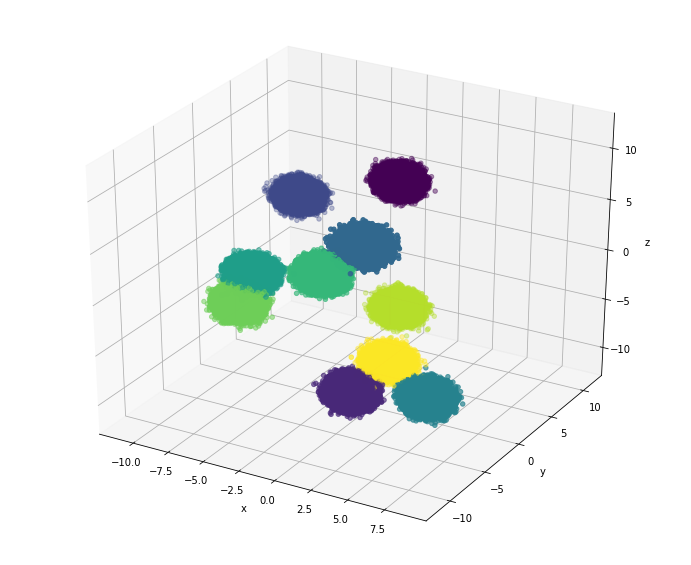

In [9]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(X[:,0], X[:,1], X[:,2], c=y)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [10]:
from pyspark.sql import SparkSession  
# spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.appName("Python Spark Data Exploration")\
           .config("spark.some.config.option", "some-value").getOrCreate()

In [27]:
filename = "/Users/dengkun/Desktop/598/final project/input.csv"
df = spark.read.options(header=True, inferSchema=True).csv(filename)

In [12]:
df.show()

+-----+-------------------+-------------------+-------------------+
|   id|                  x|                  y|                  z|
+-----+-------------------+-------------------+-------------------+
| row0|-0.9250765631699953|  5.587635766648073|  -5.79046952227982|
| row1|-0.2098629973679263|  2.396009855398736| -8.351260923567967|
| row2| -8.170318766154569|   6.77495927954504| 2.3212999158548784|
| row3|  1.583763985464586| -6.613721117595232| -7.266501240919666|
| row4|  6.063058680950792| -5.543061326275883|  -6.52685738894505|
| row5| -7.313405230645829| -3.934766368859693|-2.7878283187974535|
| row6|-0.3028344622076611|  2.045269063356746| -10.22357503924431|
| row7|  2.054575413305788|  -7.45462063259059| -7.336115848631289|
| row8|   4.25311350317207|-10.584184977675209|  9.490654513605884|
| row9|  4.536098460492221|  -8.99908920276137|  9.348184260654218|
|row10| 1.4117374484465053| -7.512571340227722| -7.101776933861026|
|row11|0.32396196147836037| 2.4861615437916997| 

In [29]:
df_feat = df.select(*(df[c].cast("float").alias(c) for c in df.columns[1:]))
df_feat.show()

+-----------+----------+----------+
|          x|         y|         z|
+-----------+----------+----------+
|-0.92507654|  5.587636|-5.7904696|
|-0.20986299|   2.39601| -8.351261|
|  -8.170319|  6.774959|    2.3213|
|   1.583764| -6.613721|-7.2665014|
|   6.063059|-5.5430613|-6.5268574|
|  -7.313405|-3.9347663|-2.7878282|
|-0.30283445|  2.045269|-10.223575|
|  2.0545754| -7.454621| -7.336116|
|  4.2531133|-10.584185|  9.490655|
|  4.5360985| -8.999089|  9.348185|
|  1.4117374|-7.5125713| -7.101777|
| 0.32396197| 2.4861615| -8.841425|
| -1.4301113| 5.9471564|-6.4717407|
|  6.6425085|-5.9652314| -6.030607|
|-0.14263816| 1.9568878| -9.457641|
|  -7.071624| -4.703513| 0.6690309|
|  -9.330306|  8.039813| 1.5558163|
|  3.4020739|  -9.41131|  9.938026|
| -2.0074935|-3.9146855| 2.9430754|
|  6.7373357| -4.417411|-6.8919024|
+-----------+----------+----------+
only showing top 20 rows



In [14]:
features = ['x', 'y', 'z']

In [15]:
for col in df.columns:
    if col in features:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+-----+-----------+----------+----------+
|   id|          x|         y|         z|
+-----+-----------+----------+----------+
| row0|-0.92507654|  5.587636|-5.7904696|
| row1|-0.20986299|   2.39601| -8.351261|
| row2|  -8.170319|  6.774959|    2.3213|
| row3|   1.583764| -6.613721|-7.2665014|
| row4|   6.063059|-5.5430613|-6.5268574|
| row5|  -7.313405|-3.9347663|-2.7878282|
| row6|-0.30283445|  2.045269|-10.223575|
| row7|  2.0545754| -7.454621| -7.336116|
| row8|  4.2531133|-10.584185|  9.490655|
| row9|  4.5360985| -8.999089|  9.348185|
|row10|  1.4117374|-7.5125713| -7.101777|
|row11| 0.32396197| 2.4861615| -8.841425|
|row12| -1.4301113| 5.9471564|-6.4717407|
|row13|  6.6425085|-5.9652314| -6.030607|
|row14|-0.14263816| 1.9568878| -9.457641|
|row15|  -7.071624| -4.703513| 0.6690309|
|row16|  -9.330306|  8.039813| 1.5558163|
|row17|  3.4020739|  -9.41131|  9.938026|
|row18| -2.0074935|-3.9146855| 2.9430754|
|row19|  6.7373357| -4.417411|-6.8919024|
+-----+-----------+----------+----

In [16]:
vecAssembler = VectorAssembler(inputCols=features, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('id', 'features')
df_kmeans.show()

+-----+--------------------+
|   id|            features|
+-----+--------------------+
| row0|[-0.9250765442848...|
| row1|[-0.2098629921674...|
| row2|[-8.1703186035156...|
| row3|[1.58376395702362...|
| row4|[6.06305885314941...|
| row5|[-7.3134050369262...|
| row6|[-0.3028344511985...|
| row7|[2.05457544326782...|
| row8|[4.25311326980590...|
| row9|[4.53609848022460...|
|row10|[1.41173744201660...|
|row11|[0.32396197319030...|
|row12|[-1.4301112890243...|
|row13|[6.64250850677490...|
|row14|[-0.1426381617784...|
|row15|[-7.0716238021850...|
|row16|[-9.3303060531616...|
|row17|[3.40207386016845...|
|row18|[-2.0074934959411...|
|row19|[6.73733568191528...|
+-----+--------------------+
only showing top 20 rows



In [17]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [18]:
silhouette = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    silhouette[k] = evaluator.evaluate(predictions)

Text(0,0.5,'silhouette')

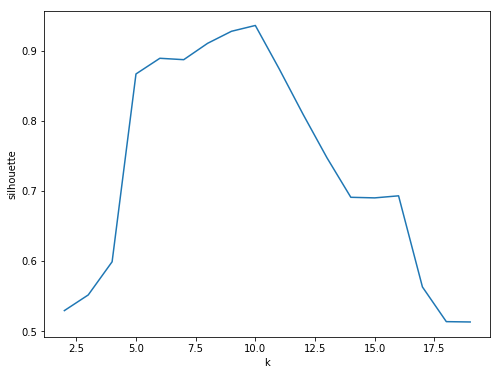

In [19]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette[2:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette')

In [20]:
kmeans = KMeans().setK(5).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
predictions = model.transform(df_kmeans)
evaluator = ClusteringEvaluator()
silhouette[k] = evaluator.evaluate(predictions)

In [21]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-1.35830165 -4.17161121  2.23476806]
[-2.50430708  9.00170339  4.64285057]
[-8.83374594  7.32167374  2.01162321]
[ 1.96861275 -6.88755447 -6.87712746]
[ 4.15189062 -9.59198221  9.40063602]
[ 6.64188032 -5.76335036 -6.36965692]
[-7.20857445 -4.1543232  -2.66578327]
[ 0.2829463   1.84613462 -9.06505135]
[-6.3325844  -3.925563    0.49155571]
[-0.88491775  5.70065609 -6.00831744]


In [22]:
transformed = model.transform(df_kmeans).select('id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(id='row0', prediction=9), Row(id='row1', prediction=7), Row(id='row2', prediction=2)]


In [23]:
transformed.show(10)

+----+----------+
|  id|prediction|
+----+----------+
|row0|         9|
|row1|         7|
|row2|         2|
|row3|         3|
|row4|         5|
|row5|         6|
|row6|         7|
|row7|         3|
|row8|         4|
|row9|         4|
+----+----------+
only showing top 10 rows



In [24]:
df_pred = transformed.join(df, 'id')
df_pred.show()

+---------+----------+-----------+----------+----------+
|       id|prediction|          x|         y|         z|
+---------+----------+-----------+----------+----------+
|row100093|         0| -1.1332687| -4.194967| 2.4416203|
|row100200|         1| -2.5354502|  8.941847| 4.6613994|
|row100356|         5|   6.814359| -5.945131|-5.7430987|
| row10044|         2|  -9.484745|  7.164065|  1.896777|
|row100578|         9|-0.43049732|  5.205617| -6.224876|
|row100888|         0| -1.1964002|-3.8600318| 1.9535162|
|row101217|         6| -7.9125886|-4.3994517|-2.0729105|
|row101689|         6|  -7.675096|-4.7346854|-3.4886727|
|row101831|         8|   -6.83433|-3.9891033| 0.2009155|
|row102220|         2|  -8.657342|  7.556673| 1.1812785|
| row10232|         0| -1.3604381|-4.4441013| 1.8473597|
|row102323|         9|-0.40533775|  5.364826|-6.0111737|
|row102395|         1| -2.8171613|  8.341621| 4.8085837|
|row102809|         5|   6.470855| -5.359395|  -6.24095|
|row102828|         4|   4.9930

In [25]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,x,y,z
id,,,,
row100093,0,-1.133269,-4.194967,2.441620
row100200,1,-2.535450,8.941847,4.661399
row100356,5,6.814359,-5.945131,-5.743099
row10044,2,-9.484745,7.164065,1.896777
row100578,9,-0.430497,5.205617,-6.224876


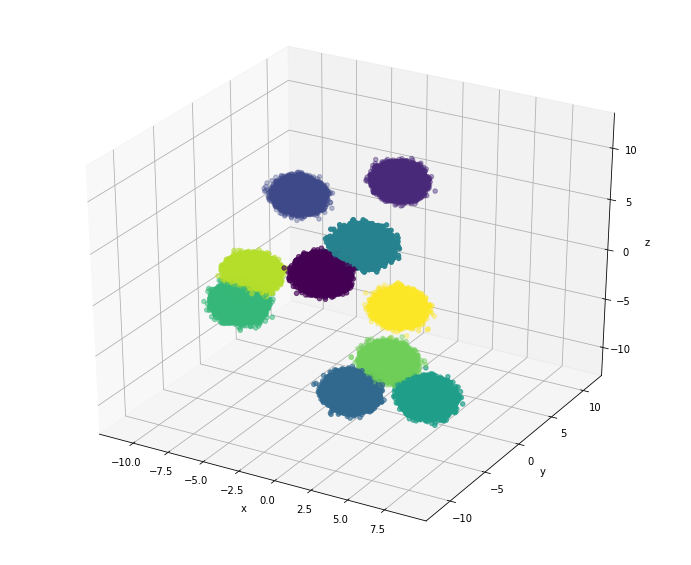

In [26]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.x, pddf_pred.y, pddf_pred.z, c=pddf_pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()